# Modelado de Topics

In [1]:
import random
import pandas as pd

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


## Cargamos datos

Vamos a utilizar para le análisis de sentimientos las reviews de Amazón de los siguientes temas: 
    Automotive
    Baby
    Digital music
    Musical instruments
    Office products
    Pet supplies

Cargamos 5000 reviews de cada tema.

In [2]:
import glob
# Primero especificamos un patrón del archivo y lo pasamos como parámetro en la función glob
json_files = glob.glob('datos/*.json')
# Mostrar el archivo csv_files, el cual es una lista de nombres
list_data = []
  
# Escribimos un loop que irá a través de cada uno de los nombres de archivo a través de globbing y el resultado final será la lista dataframes

for filename in json_files:
    data = pd.read_json(filename, lines = True)
    list_data.append(data[:5000])

#Para chequear que todo está bien, mostramos la list_data por consola
list_data
 
df=pd.concat(list_data,ignore_index=True)

Nos quedamos solo con la columna que nos interesa **reviewText**

In [3]:
df = df[['reviewText']]
df.dropna(inplace=True)

## Preprocesado

Realizamos un poco de prepocesado de los reviews. Ponemos todo en minúsculas, eliminamos carateres extraños y eliminamos números.

In [4]:
import re
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df
data_clean = clean_text(df, 'reviewText', 'reviewText_clean')
data_clean.head()

,reviewText,reviewText_clean
0,I needed a set of jumper cables for my new car...,i needed a set of jumper cables for my new car...
1,"These long cables work fine for my truck, but ...",these long cables work fine for my truck but ...
2,Can't comment much on these since they have no...,can t comment much on these since they have no...
3,I absolutley love Amazon!!! For the price of ...,i absolutley love amazon for the price of ...
4,I purchased the 12' feet long cable set and th...,i purchased the feet long cable set and they...


Eliminamos stop words

In [5]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
data_clean['reviewText_clean'] = data_clean['reviewText_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oscar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,reviewText,reviewText_clean
0,I needed a set of jumper cables for my new car...,needed set jumper cables new car good reviews ...
1,"These long cables work fine for my truck, but ...",long cables work fine truck quality seems litt...
2,Can't comment much on these since they have no...,comment much since yet used come back update r...
3,I absolutley love Amazon!!! For the price of ...,absolutley love amazon price set cheap booster...
4,I purchased the 12' feet long cable set and th...,purchased feet long cable set arrived retail c...


Eliminamos palabras menores que dos letras, no utilizo otro filtro mayor porque como yo estoy utilizando reviews de productos de coces la palabra car puede er determinante para detectar un topic por ejemplo.

In [6]:
data_clean['reviewText_clean'] = data_clean['reviewText_clean'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
data_clean.head()

,reviewText,reviewText_clean
0,I needed a set of jumper cables for my new car...,needed set jumper cables new car good reviews ...
1,"These long cables work fine for my truck, but ...",long cables work fine truck quality seems litt...
2,Can't comment much on these since they have no...,comment much since yet used come back update r...
3,I absolutley love Amazon!!! For the price of ...,absolutley love amazon price set cheap booster...
4,I purchased the 12' feet long cable set and th...,purchased feet long cable set arrived retail c...


In [7]:
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [8]:
data_clean['reviewText_clean'] = data_clean['reviewText_clean'].apply(lambda x: ' '.join([get_lemma2(word) for word in x.split() ]))
data_clean.head()

,reviewText,reviewText_clean
0,I needed a set of jumper cables for my new car...,needed set jumper cable new car good review go...
1,"These long cables work fine for my truck, but ...",long cable work fine truck quality seems littl...
2,Can't comment much on these since they have no...,comment much since yet used come back update r...
3,I absolutley love Amazon!!! For the price of ...,absolutley love amazon price set cheap booster...
4,I purchased the 12' feet long cable set and th...,purchased foot long cable set arrived retail c...


## Visualizacion de palabras mas usadas

In [9]:
long1_string = ','.join(list(df['reviewText_clean'].values))

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

In [11]:
words_nltk = long1_string.split()

In [12]:
wf = Counter(words_nltk)

In [13]:
wf_most_common = wf.most_common(10)

In [14]:
wf_most_common

[('one', 16778),
 ('album', 12612),
 ('like', 11914),
 ('quot', 11327),
 ('song', 9813),
 ('use', 9771),
 ('great', 9597),
 ('time', 9111),
 ('get', 8887),
 ('good', 8546)]

In [15]:
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]

In [16]:
freqs, words = zip(*sorted(zip(freqs, words)))

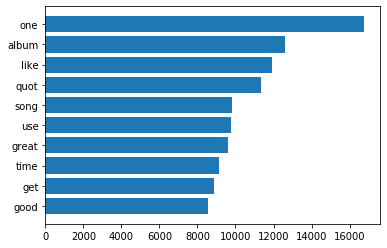

In [17]:
plt.barh(words, freqs)
plt.show()

Vemos que los tokens con mas frecuencia algunas refereridas ala música como album, song.

Ahora vamos a ver los bigramas y trigramas más frecuentes

In [18]:
# from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from nltk.probability import FreqDist

In [19]:
bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))

In [20]:
bigrams_[:10]

[('needed', 'set'),
 ('set', 'jumper'),
 ('jumper', 'cable'),
 ('cable', 'new'),
 ('new', 'car'),
 ('car', 'good'),
 ('good', 'review'),
 ('review', 'good'),
 ('good', 'price'),
 ('price', 'used')]

In [21]:
trigrams_[:10]

[('needed', 'set', 'jumper'),
 ('set', 'jumper', 'cable'),
 ('jumper', 'cable', 'new'),
 ('cable', 'new', 'car'),
 ('new', 'car', 'good'),
 ('car', 'good', 'review'),
 ('good', 'review', 'good'),
 ('review', 'good', 'price'),
 ('good', 'price', 'used'),
 ('price', 'used', 'time')]

In [22]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

In [23]:
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [24]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

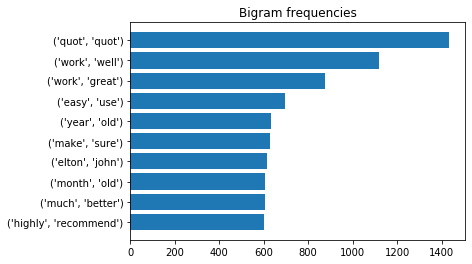

In [25]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

Aquí podemos ver uno muy visible como es el cantante Elton John

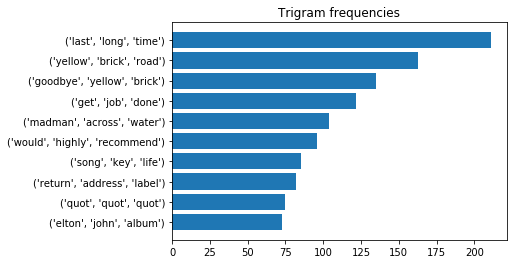

In [26]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

Si se repite Elton Jhon igual es porque en la época que se sacarón lo reviews Elton Jhon había lanzado un disco.

In [28]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

In [29]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
           lda_tokens = [token for token in tokens]
    return lda_tokens

In [30]:
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
           result.append(token)
    return result

In [31]:
print('Original text:\n{}\n\n'.format(df['reviewText_clean'][1]))
print('Original text:\n{}\n\n'.format(text_preprocessing(df['reviewText_clean'][1])))

Original text:
long cable work fine truck quality seems little shabby side money expecting dollar snap jumper cable seem like would see chinese knock shop like harbor freight buck


Original text:
['long', 'cable', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cable', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'buck']




In [32]:
processed_texts = []
for text in df['reviewText_clean']:
    processed_texts.append(text_preprocessing(text))

In [33]:
print(processed_texts[0])

['needed', 'set', 'jumper', 'cable', 'new', 'car', 'good', 'review', 'good', 'price', 'used', 'time', 'already', 'supposed', 'complaint', 'say', 'foot', 'really', 'ideal', 'length', 'sure', 'pull', 'front', 'bumper', 'front', 'bumper', 'plenty', 'long', 'lot', 'time', 'beside', 'another', 'car', 'get', 'really', 'close', 'would', 'recommend', 'something', 'little', 'longer', 'great', 'brand', 'get', 'version', 'though']


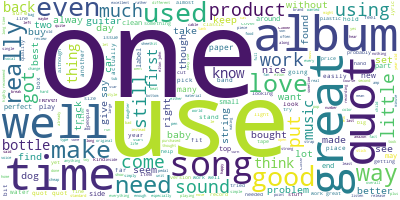

In [34]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['reviewText_clean'].values))
# Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Aquí podemos ver en forma de nubes las palabras más frecuentes.

## Creamos el diccionario

In [35]:
dictionary = Dictionary(processed_texts)

In [36]:
len(dictionary)

40797

In [37]:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

In [38]:
len(corpus)

30000

## Entrenamos el modelo

Por defecto, pongo el número de **topics 6** que son nuestros diferentes tipos de rewiews que hemos cogido

In [39]:
num_topics = 6

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto',
    random_state =True
)

In [40]:
lda_model.show_topics()

[(0,
  '0.026*"album" + 0.023*"quot" + 0.020*"song" + 0.011*"one" + 0.008*"music" + 0.008*"track" + 0.008*"like" + 0.007*"sound" + 0.006*"best" + 0.006*"love"'),
 (1,
  '0.022*"dog" + 0.016*"one" + 0.012*"cat" + 0.012*"get" + 0.012*"time" + 0.011*"food" + 0.010*"like" + 0.010*"would" + 0.010*"love" + 0.009*"product"'),
 (2,
  '0.021*"tape" + 0.016*"good" + 0.015*"great" + 0.015*"price" + 0.012*"guitar" + 0.012*"quality" + 0.011*"work" + 0.011*"well" + 0.011*"use" + 0.011*"string"'),
 (3,
  '0.034*"water" + 0.029*"label" + 0.022*"use" + 0.020*"product" + 0.016*"paper" + 0.013*"easy" + 0.013*"clean" + 0.011*"card" + 0.010*"printer" + 0.010*"avery"'),
 (4,
  '0.026*"filter" + 0.023*"tank" + 0.016*"pen" + 0.014*"work" + 0.013*"use" + 0.011*"bottle" + 0.009*"paper" + 0.007*"kit" + 0.007*"need" + 0.007*"pump"'),
 (5,
  '0.014*"one" + 0.010*"hold" + 0.010*"use" + 0.009*"little" + 0.009*"size" + 0.009*"fit" + 0.009*"easy" + 0.008*"well" + 0.008*"like" + 0.008*"small"')]

In [41]:
word_dict = {};
for i in range(num_topics):
    words = lda_model.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06
0,album,dog,tape,water,filter,one
1,quot,one,good,label,tank,hold
2,song,cat,great,use,pen,use
3,one,get,price,product,work,little
4,music,time,guitar,paper,use,size
5,track,food,quality,easy,bottle,fit
6,like,like,work,clean,paper,easy
7,sound,would,well,card,kit,well
8,best,love,use,printer,need,like
9,love,product,string,avery,pump,small


In [42]:
# Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.890635621342154

Coherence Score:  0.43201908178843434


In [43]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

C:\Users\Oscar\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.237541 -0.165228       1        1  29.133251
1     -0.096572  0.072028       2        1  19.830267
2     -0.010066  0.079432       3        1  17.170540
5      0.011075  0.150079       4        1  16.750830
4      0.110405  0.024924       5        1   9.357057
3      0.222698 -0.161235       6        1   7.758056, topic_info=      Category          Freq   Term         Total  loglift  logprob
10898  Default  11818.000000  album  11818.000000  30.0000  30.0000
10952  Default  10533.000000   quot  10533.000000  29.0000  29.0000
11748  Default   9137.000000   song   9137.000000  28.0000  28.0000
2021   Default   6908.000000    dog   6908.000000  27.0000  27.0000
799    Default   4499.000000  water   4499.000000  26.0000  26.0000
...        ...           ...    ...           ...      ...      ...
13      Topic6    877.823730  great  10478.574219   0.0768  -4.9415
133     Topic6    699.841492   also   6394.706055   0.3441  -5.1681
820     Topic6    531.431213  clear   1345.361572   1.6276  -5.4434
335     Topic6    677.068481   well   8762.602539  -0.0040  -5.2012
35      Topic6    587.967285   time   8517.957031  -0.1168  -5.3423

[434 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
32815      3  0.997206  addario
4339       1  0.029480  address
4339       3  0.003931  address
4339       6  0.964965  address
1005       1  0.095305      ago
...      ...       ...      ...
415        2  0.519771     year
415        3  0.121564     year
415        4  0.027835     year
415        5  0.092404     year
415        6  0.011361     year

[914 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 6, 5, 4])

Vamos a mira si podemos sacar de que van los topics:

El **topic 1** habla de música, de discos,canciones

El **topic 2** habla de productos para mascotas, como comida, antipulgas

El **topic 3** habla principalmente de intrumentos battery, guitar, sobre el sonido y el precio

El **topic 4** podría hablar de montajes de cosas ya sean muebles tronas, etc.. y si son grandes, pequeñas o al montar se ajustan bien.

El **topic 5** yo diría que habla de productos relacionados con el coche, pero hay algún termino que me despista porque parece que esta mezclando productos de oficina como pen, pencil, calculator, ink.

El **topic 6** principalmente habla de productos de oficina como papel, taretas, impresoras, aunque en poca medida tambien se mezcla con comida para peces.

In [ ]:
pyLDAvis.save_html(vis, 'resultado/topics_vis_0.html')

## Obtener el número óptimo de topics 

In [44]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [45]:
start_ = 4
end_ = 15
step_ = 1

In [46]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=processed_texts,
    start=start_,
    limit=end_,
    step=step_
)

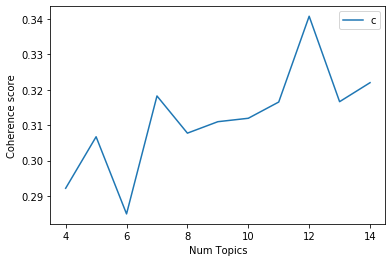

In [47]:
x = range(start_, end_, step_)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

EL mejor de score de coherencia nos sale **12 topics**, vamos a crear un modelo con 5 y otro con 12 y miramos si tiene setido la clasificación

In [48]:
num_topics = 5

lda_model5 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto',
    random_state =True
)

In [49]:
lda_model5.show_topics()

[(0,
  '0.036*"love" + 0.020*"one" + 0.020*"toy" + 0.015*"little" + 0.011*"like" + 0.010*"old" + 0.009*"baby" + 0.009*"around" + 0.009*"get" + 0.008*"great"'),
 (1,
  '0.021*"dog" + 0.013*"water" + 0.012*"cat" + 0.012*"product" + 0.011*"food" + 0.011*"one" + 0.010*"time" + 0.009*"get" + 0.008*"day" + 0.007*"like"'),
 (2,
  '0.024*"album" + 0.021*"quot" + 0.019*"song" + 0.011*"one" + 0.008*"like" + 0.008*"music" + 0.008*"track" + 0.007*"sound" + 0.006*"best" + 0.006*"time"'),
 (3,
  '0.017*"tape" + 0.016*"use" + 0.013*"label" + 0.012*"paper" + 0.009*"easy" + 0.009*"product" + 0.008*"well" + 0.008*"pen" + 0.007*"like" + 0.007*"used"'),
 (4,
  '0.013*"filter" + 0.012*"good" + 0.011*"great" + 0.011*"one" + 0.011*"work" + 0.010*"tank" + 0.010*"guitar" + 0.009*"use" + 0.009*"price" + 0.009*"string"')]

In [50]:
# Perplexity
print('\nPerplexity: ', lda_model5.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda5 = CoherenceModel(model=lda_model5, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda5 = coherence_model_lda5.get_coherence()
print('\nCoherence Score: ', coherence_lda5)


Perplexity:  -7.852488023458604

Coherence Score:  0.39570780128322147


En cuanto a la evalución el modelo empeora un poco respecto del anterior pero es casi despreciable

In [51]:
num_topics = 12

lda_model12 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto',
    random_state =True
)

In [52]:
lda_model12.show_topics()

[(0,
  '0.247*"quot" + 0.057*"elton" + 0.030*"hit" + 0.012*"amp" + 0.011*"chart" + 0.009*"bernie" + 0.009*"master" + 0.008*"highlight" + 0.008*"taupin" + 0.007*"stone"'),
 (3,
  '0.054*"label" + 0.051*"paper" + 0.020*"sheet" + 0.020*"card" + 0.019*"ink" + 0.018*"printer" + 0.018*"avery" + 0.016*"pen" + 0.015*"print" + 0.015*"tab"'),
 (10,
  '0.061*"water" + 0.047*"filter" + 0.042*"tank" + 0.027*"fish" + 0.023*"bottle" + 0.021*"clean" + 0.017*"litter" + 0.014*"aquarium" + 0.013*"use" + 0.013*"dry"'),
 (9,
  '0.056*"guitar" + 0.049*"string" + 0.028*"ball" + 0.027*"pick" + 0.020*"pen" + 0.020*"sound" + 0.017*"feel" + 0.017*"last" + 0.016*"like" + 0.014*"black"'),
 (8,
  '0.014*"time" + 0.012*"come" + 0.012*"also" + 0.011*"level" + 0.010*"set" + 0.010*"one" + 0.010*"fast" + 0.010*"john" + 0.010*"take" + 0.010*"came"'),
 (7,
  '0.058*"one" + 0.054*"love" + 0.040*"easy" + 0.026*"bought" + 0.022*"keep" + 0.021*"great" + 0.021*"old" + 0.020*"put" + 0.016*"recommend" + 0.014*"really"'),
 (2,
  

In [53]:
# Perplexity
print('\nPerplexity: ', lda_model12.log_perplexity(corpus))  # Medida de qué tan bueno es el modelo. Cuanto más bajo, mejor

# Coherence Score
coherence_model_lda12 = CoherenceModel(model=lda_model12, texts=processed_texts, dictionary=dictionary, coherence='c_v')
coherence_lda12 = coherence_model_lda12.get_coherence()
print('\nCoherence Score: ', coherence_lda12)


Perplexity:  -8.976798346580077

Coherence Score:  0.45788492696260263


El modelo de 12 topics como era de esperar es el que mejor **Perplexity** y **Coherence Score** nos proporciona

In [54]:
word_dict = {};
for i in range(num_topics):
    words = lda_model12.show_topic(i, topn = 20)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10,Topic #11,Topic #12
0,quot,good,tape,label,work,dog,album,one,time,guitar,water,hold
1,elton,cat,price,paper,well,toy,song,love,come,string,filter,fit
2,hit,food,product,sheet,great,get,one,easy,also,ball,tank,plastic
3,amp,like,quality,card,need,month,music,bought,level,pick,fish,use
4,chart,would,use,ink,use,little,track,keep,set,pen,bottle,stand
5,bernie,even,amazon,printer,product,time,sound,great,one,sound,clean,bag
6,master,year,buy,avery,used,like,like,old,fast,feel,litter,heavy
7,highlight,day,box,pen,fine,one,best,put,john,last,aquarium,top
8,taupin,say,brand,print,job,back,love,recommend,take,like,use,place
9,stone,time,store,tab,get,small,rock,really,came,black,dry,side


In [55]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model12, corpus, dictionary)
vis

C:\Users\Oscar\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.077822  0.189159       1        1  21.140072
1     -0.122606  0.169611       2        1  12.962209
11    -0.049585 -0.139061       3        1   9.818983
2     -0.078619 -0.090068       4        1   8.489923
4     -0.127152 -0.067342       5        1   8.447714
7     -0.096675  0.035029       6        1   8.293349
5     -0.134879  0.127174       7        1   8.075773
8     -0.032396  0.095797       8        1   6.238091
10     0.040493 -0.218877       9        1   5.480816
9      0.001159  0.015697      10        1   4.565583
3      0.120547 -0.224251      11        1   3.901427
0      0.401891  0.107133      12        1   2.586063, topic_info=      Category          Freq    Term         Total  loglift  logprob
10952  Default  10126.000000    quot  10126.000000  30.0000  30.0000
58     Default   8960.000000    work   8960.000000  29.0000  29.0000
335    Default   9326.000000    well   9326.000000  28.0000  28.0000
10898  Default  12762.000000   album  12762.000000  27.0000  27.0000
2021   Default   7324.000000     dog   7324.000000  26.0000  26.0000
...        ...           ...     ...           ...      ...      ...
2988   Topic12    203.083618   video    332.846039   3.1610  -5.3067
6828   Topic12    166.548203  rocker    274.594971   3.1550  -5.5051
1731   Topic12    171.597229  filler    317.510132   3.0397  -5.4752
1475   Topic12    165.859100  single   1802.799194   1.2691  -5.5092
11748  Topic12    151.020370    song   9858.372070  -0.5236  -5.6029

[747 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
17400      1  0.114801  acoustic
17400     10  0.884871  acoustic
402        1  0.135576    across
402        3  0.018412    across
402        8  0.831867    across
...      ...       ...       ...
415        9  0.009746      year
415       10  0.050144      year
415       11  0.001415      year
415       12  0.001729      year
2260       8  0.997235    yellow

[2076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 12, 3, 5, 8, 6, 9, 11, 10, 4, 1])

Aquí al tener 12 topics, es de esperar que tengamos que agrupar algunos para decir que tratan sobre el mismo tema.

El topic 1 habla sobre disco de música, el tipo, de como suenan.

El topic 2 parece que habla algo relacionado con los gatos y la comida.

El topic 3 habla sobre ajustes, pero no se muy bien sacar alguna conclusión

El topic 4 puede habla sobre el precio y la calidad de las cintas

El topic 5 no le encuentro sentido

El topic 6 algo sobre los niños y la habitación, la silla, pero no llego a ninguna conclusión

El topic 7 sobre juguetes para perros y antipulgas

El topic 8 no le encuentro sentido a la palabras

El topic 9 parece que habla sobre productos de limpieza para el coche

El topic 10 puede hablar sobre temas de la guitarra eléctrica , acústica, etc..

El topic 11 parece que habla sobre artículos de oficina

El topic 12 parece que habla sobre música porque aparecen varios cantantes.

Aquí parece que el topic 1 y el topic 12 parece que les ppodríamos agrupar en uno que hable de música El topic 2 y topic 7 que hablan de perrors y gatos agruparles en mascotas.

In [ ]:
pyLDAvis.save_html(vis, 'resultado/topics_vis_1.html')

Por último vamos a ver que topics nos salen si escogemos un número de Topics menos que 6, en concreto 5:

In [56]:
# Visualizar los topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model5, corpus, dictionary)
vis

C:\Users\Oscar\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.195482 -0.172584       1        1  30.315416
4      0.100011 -0.031847       2        1  21.824039
1      0.080475  0.025021       3        1  18.810875
3      0.151514 -0.028029       4        1  18.004837
0     -0.136517  0.207439       5        1  11.044827, topic_info=      Category          Freq    Term         Total  loglift  logprob
10898  Default  11575.000000   album  11575.000000  30.0000  30.0000
93     Default   8966.000000    love   8966.000000  29.0000  29.0000
10952  Default  10317.000000    quot  10317.000000  28.0000  28.0000
11748  Default   8949.000000    song   8949.000000  27.0000  27.0000
2021   Default   6357.000000     dog   6357.000000  26.0000  26.0000
...        ...           ...     ...           ...      ...      ...
314     Topic5    827.205139   thing   4092.928223   0.6042  -5.3541
306     Topic5    787.828003    take   2976.035645   0.8741  -5.4029
396     Topic5    768.989746     got   3153.498535   0.7920  -5.4271
68      Topic5    769.954407  bought   3276.695312   0.7549  -5.4258
82      Topic5    772.395203   first   4577.422852   0.4238  -5.4227

[361 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1745      2  0.988018  accurate
1745      3  0.005298  accurate
1745      4  0.005298  accurate
4022      2  0.998073   adapter
4339      1  0.013363   address
...     ...       ...       ...
415       1  0.287095      year
415       2  0.217349      year
415       3  0.329628      year
415       4  0.117686      year
415       5  0.048300      year

[658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 1])

El **topic 1** parece que habla de música

El **topic 2** hay una mezcla de terminos del automovil como puede ser filtro, deposito con instumentos musicales y relacionados con el precio

El **topic 3** parece que habla soble productos de mascotas

El **topic 4** habla de productos de oficina

El **topic 5** parece que habla de juguetes para baby

In [ ]:
pyLDAvis.save_html(vis, 'resultado/topics_vis_2.html')